In [ ]:
from unityagents import UnityEnvironment
import numpy as np
from agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [ ]:
env = UnityEnvironment(file_name="Banana.exe")

In [ ]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

I solved the environemnt using a Deep Q Network. The neural network can be located in the model.py file.  It is a simple feedfoward network with 3 fully connected layers. Each of the hidden layers have 128 unit each and use rectified linear units as the activation function. 

The agent implents experience replay. The implementation of the replay buffer can be found in replay_buffer.py. The size of the buffer is defined by the buffer_size parameter and the number of experiences used per training run is set by the batch size parameter.

The agent uses fixed Q-Targets. It initialize two q-networks one target and one local. It updates the target every 4 steps. 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Get environment descriptors 
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize agent and set hyperparameters
agent = Agent(
    action_size=action_size,
    state_size=state_size,
    batch_size=64,
    buffer_size=100000,
    gamma=0.99,
    tau=0.001,
    lr=0.0005,
    update_step_interval=4,
    seed=0,
    device=device
) 

Next cell trains the agent with an early stop when it reaches 13 point on average over 100 episodes

The model is saved in the checkpoint.pth file after training succefully.

In [5]:
def dqn(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.997):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps).astype(int)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()




Episode 100	Average Score: 0.30
Episode 200	Average Score: 0.78
Episode 300	Average Score: 1.78
Episode 400	Average Score: 4.40
Episode 500	Average Score: 5.39
Episode 600	Average Score: 7.34
Episode 700	Average Score: 9.68
Episode 800	Average Score: 10.52
Episode 900	Average Score: 10.84
Episode 1000	Average Score: 11.62
Episode 1100	Average Score: 12.73
Episode 1200	Average Score: 12.91
Episode 1201	Average Score: 13.03
Environment solved in 1101 episodes!	Average Score: 13.03


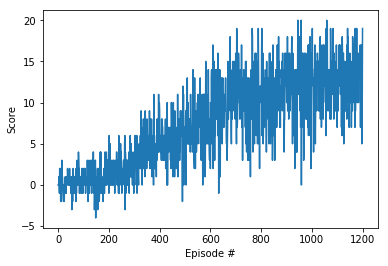

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


## future improvements

This model was a simple DQN network. Obvious next steps would be to try adding prioritized experience replay, try double  q-learning and, switch to a dueling dqn architecture. 


